In [1]:
import time
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
import pandas as pd
import seaborn as sns
import math
import sys
import os
from sabreMod import sosf,sosfh
from scipy import interpolate

In [2]:
start=time.time()

In [3]:
orion=pd.read_table('Obs/Orion.csv', delimiter=',')
orion.describe()

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-0.133333,0.300000,0.366667,0.095833,0.525000,0.062500,-0.700000,-0.295833,0.141667,-0.279167,...,-1.654167,-2.845833,-1.891667,-1.308333,-0.825000,-1.041667,-0.633333,-0.166667,0.229167,0.450000
std,0.814898,1.298494,0.995497,1.257492,1.217713,1.553905,2.062291,3.833092,2.790343,2.699272,...,3.067640,2.998692,2.519647,2.137230,2.639376,1.916500,1.313034,0.755079,0.859464,1.595919
min,-3.900000,-2.500000,0.000000,-3.500000,-1.000000,-2.900000,-4.500000,-7.000000,-3.100000,-3.900000,...,-7.400000,-9.100000,-6.400000,-6.000000,-6.100000,-5.100000,-4.600000,-3.700000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,-2.325000,-2.550000,-2.325000,-2.100000,...,-3.150000,-5.000000,-4.725000,-2.625000,-2.200000,-1.925000,-0.175000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.400000,-0.300000,-0.050000,...,-1.900000,-2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.200000,0.925000,0.000000,0.000000,0.125000,1.000000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.700000,4.300000,4.600000,3.200000,3.900000,5.100000,3.800000,10.400000,6.900000,8.900000,...,6.800000,1.900000,1.400000,3.100000,7.400000,1.400000,0.500000,0.000000,4.000000,7.000000


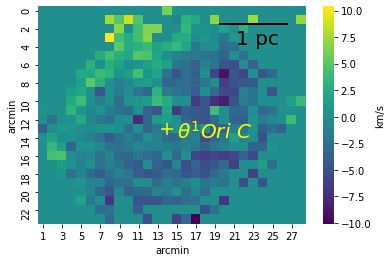

In [4]:
fig, ax = plt.subplots()
sns.heatmap(orion,cmap="viridis",cbar_kws={'label': 'km/s'})
plt.scatter(13.5, 13.5, marker='+', color='yellow', s=150)
ax.set(xlabel='arcmin', ylabel='arcmin')

ax.text(0.9, 0.81, '1 pc',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=20)
    
plt.axhline(y=2, xmin=0.68, xmax=0.93, linewidth=2, color = 'k')

plt.text(14.5, 14.5, '$θ^{1}Ori\ C$', fontsize=20, color='yellow')

plt.show()

In [5]:
df=orion.stack().reset_index().rename(columns={'level_0':'RAdeg', 'level_1':'DEdeg', 0:'RVHalpha'})
df.describe()

,RAdeg,RVHalpha
count,672.000000,672.000000
mean,11.500000,-0.667857
std,6.927343,2.440544
min,0.000000,-10.100000
25%,5.750000,-2.000000
50%,11.500000,0.000000
75%,17.250000,0.000000
max,23.000000,10.400000


In [6]:
df.RAdeg=1.0*df.RAdeg

In [7]:
df.DEdeg=pd.to_numeric(df.DEdeg)*1.0

In [8]:
df0 = pd.DataFrame({'X': df.RAdeg, 'Y': df.DEdeg, 'RV': df.RVHalpha})
df0.describe()

,X,Y,RV
count,672.000000,672.000000,672.000000
mean,11.500000,14.500000,-0.667857
std,6.927343,8.083764,2.440544
min,0.000000,1.000000,-10.100000
25%,5.750000,7.750000,-2.000000
50%,11.500000,14.500000,0.000000
75%,17.250000,21.250000,0.000000
max,23.000000,28.000000,10.400000


In [9]:
df0["RV"] = df0["RV"].replace(['0', 0], np.nan)


In [10]:
df0.describe()

,X,Y,RV
count,672.000000,672.000000,359.000000
mean,11.500000,14.500000,-1.250139
std,6.927343,8.083764,3.230147
min,0.000000,1.000000,-10.100000
25%,5.750000,7.750000,-3.400000
50%,11.500000,14.500000,-1.800000
75%,17.250000,21.250000,0.700000
max,23.000000,28.000000,10.400000


In [11]:
data=df0

Text(0.5, 6.79999999999999, 'Radial velocity [km/s]')

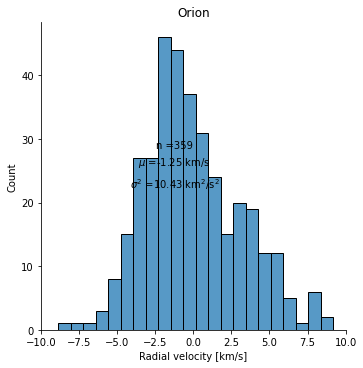

In [12]:
#fig, ax = plt.subplots()

sns.displot(data.RV-data.RV.mean(),bins=25)
plt.xlim(-10,10)

plt.text(0.45, 0.86,'n ='+str(data.RV.count()), ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.78,'$μ$ ='+str(np.round(data.RV.mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.68,'$σ^{2}$ ='+str(np.round(data.RV.var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('Orion')

plt.xlabel('Radial velocity [km/s]')

Dr. Will SF

In [13]:
df1 = pd.DataFrame({'RA': df.RAdeg, 'DE': df.DEdeg, 'V': df.RVHalpha, '_key': 1})
#df1.describe()
df2 = df1.copy()

In [14]:
pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))
#pairs.head()

In [15]:
pairs.loc[:, 'dDE'] =(pairs.DE - pairs.DE_)
pairs.loc[:, 'dRA'] =(pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)

pairs.loc[:, 'log_s'] = np.log10(pairs.s)

pairs.loc[:, 'dV'] = pairs.V - pairs.V_
pairs.loc[:, 'dV2'] = pairs.dV**2
pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
pairs = pairs[(pairs.dDE > 0.0) & (pairs.dRA > 0.0)]

In [17]:
sig2 = pairs.dV2.mean()
sig2a = 2*np.var(df1.V)
print(f'Dotted line is 2 x sigma^2 = {sig2a:.2f}')

Dotted line is 2 x sigma^2 = 11.89


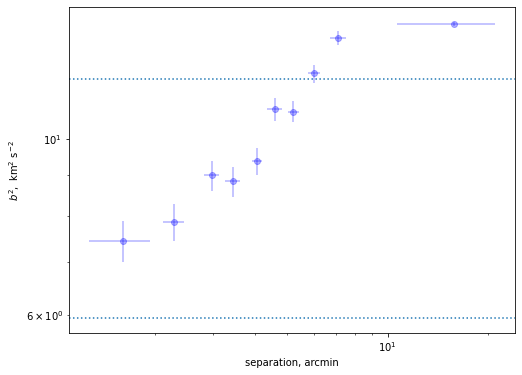

In [18]:
ngroup = 10500
groups = np.arange(len(pairs)) // ngroup
groups = np.logspace(0,np.log10(len(pairs)),len(pairs),endpoint = True) // ngroup

table = pairs[['s', 'dV2']].sort_values('s').groupby(groups[::-1]).describe()

s = table[('s', 'mean')]
e_s = table[('s', 'std')]
b2 = table[('dV2', 'mean')]
ng = table[('dV2', 'count')]
e_b2 = table[('dV2', 'std')]/np.sqrt(ng - 1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(sig2a, ls=':')
ax.axhline(0.5*sig2a, ls=':')
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.3, color="blue")
#sgrid = np.logspace(0.3, 1.65)
#ax.plot(sgrid, 38.5*sgrid**(0.8), color="k", lw=0.5)
ax.set(xscale='log', yscale='log', 
      xlabel='separation, arcmin',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
     )

#plt.text(0.1, 0.25,'n ='+str(ngroup), ha='center', va='center', transform=ax.transAxes, color='k')


None

In [19]:
table

s                                                                  \
       count       mean       std       min        25%        50%        75%   
0.0  83597.0  15.833606  5.160724  7.779037  11.606724  15.207691  19.427224   
1.0   6258.0   7.118590  0.384309  6.353270   6.834255   7.092537   7.465114   
2.0   3660.0   6.025724  0.238469  5.584832   5.800196   6.075320   6.269187   
3.0   2598.0   5.218749  0.187903  4.953266   5.080813   5.158751   5.375038   
4.0   2014.0   4.591705  0.239842  4.213648   4.414328   4.468738   4.848823   
5.0   1646.0   4.050391  0.144716  3.602135   4.041280   4.108895   4.121304   
6.0   1392.0   3.432940  0.173767  3.152350   3.161977   3.516248   3.574878   
7.0   1206.0   2.972980  0.152516  2.736108   2.817906   2.999526   3.134969   
8.0   1063.0   2.282862  0.168543  2.171252   2.207164   2.224576   2.234366   
9.0    894.0   1.605861  0.333284  1.336708   1.378157   1.406468   2.063647   

                    dV2                                                         
           max    count       mean        std  min   25%    50%    75%     max  
0.0  34.997670  83597.0  13.965665  24.746061  0.0  0.04  4.840  16.81  420.25  
1.0   7.779037   6258.0  13.401184  21.488409  0.0  0.49  4.840  16.81  187.69  
2.0   6.353270   3660.0  12.090918  19.020149  0.0  0.36  4.840  15.21  252.81  
3.0   5.584832   2598.0  10.821582  16.665449  0.0  0.25  4.000  14.44  144.00  
4.0   4.953266   2014.0  10.903049  16.233771  0.0  0.16  4.625  14.44  134.56  
5.0   4.213648   1646.0   9.373439  14.858351  0.0  0.01  3.240  12.25  108.16  
6.0   3.602135   1392.0   8.841983  14.141302  0.0  0.09  3.240  11.56  110.25  
7.0   3.152350   1206.0   8.995763  13.592736  0.0  0.09  3.610  12.25  108.16  
8.0   2.736108   1063.0   7.853989  13.764910  0.0  0.00  1.960   9.61  114.49  
9.0   2.171252    894.0   7.444843  13.234558  0.0  0.00  1.690   9.61  108.16

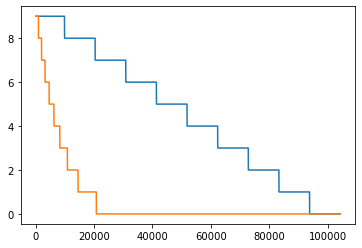

In [20]:
xx1=groups = np.arange(len(pairs)) // ngroup
xx2=groups = np.logspace(0,np.log10(len(pairs)),len(pairs),endpoint = True) // ngroup
plt.plot(xx1[::-1])
plt.plot(xx2[::-1])

In [21]:
pc=0.12
sc=s*pc
e_sc=e_s*pc
table0=[sc,b2,e_sc,e_b2]
dfx2=pd.DataFrame(table0)
dfx2=dfx2.transpose()
dfx2=dfx2.set_axis(['pc', 'S', 'ErrX', 'ErrY'], axis=1, inplace=False)
dfx2.to_csv('SFdata//Orion2.csv',mode = 'w', index=False)

In [22]:
finish=time.time()
print("Runnig time:",finish-start, "seconds" )

Runnig time: 4.004625558853149 seconds
